<font size=6>From dependencies to token level matrices</font>

In this notebook I will sketch what the workflow should look like to link what we have of dependencies and what we need for tokens
I will exemplify with tokens of _stof/noun_

## Source file example
This is what a file with dependency data looks like (from QLVLNewsCorpus)

### Import modules

In [2]:
import sys
# qlvldir = "/home/aardvark/code/typetokenQLVL"
qlvldir = "/home/tao/Projects/mariana/depmodel" # for my testing
# (I modified dephandler.py, lines 447-453 in my version, to format the read files)
sys.path.append(qlvldir)

import qlvl
print(qlvl.rootdir)
from qlvl.conf import ConfigLoader
from qlvl import CorpusFormatter

from qlvl.core.matrix import TypeTokenMatrix
from qlvl.core.graph import SentenceGraph, MacroGraph, PatternGraph
from qlvl.models.typetoken import ItemFreqHandler
from qlvl.models.deprel import DepRelHandler, read_sentence
from qlvl.deprel.deputils import split_large_file
from qlvl.specutils.deputils import parse_pattern, draw_tree, draw_match, draw_labels, get_root
from qlvl.specutils.mxutils import transform_dict_to_spmatrix

# OLD MODULES
# from qlvl.deprel.dephandler import DepRelParalleler, DepRelHandler, read_sentence
# from qlvl.deprel.deputils import split_large_file, draw_tree, draw_match, draw_labels
# from qlvl.deprel.basic import SentenceGraph, TemplateGraph, FeatureGraph, get_root


import os
# import re
# import json
# import time
# import multiprocessing as mp
# from collections import deque
# from itertools import product

# from queue import Queue
# import threading

from copy import deepcopy
# import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
%matplotlib inline

/home/tao/Projects/mariana/depmodel/qlvl


QUESTION: Are ALL those modules necessary?

ANSWER: The modules commented are non-necessary.

### Configuration
Example settings:
```
[Encoding]
file-encoding=utf-8
output-encoding=utf-8

[Data]
corpus-path=/home/enzocxt/Projects/QLVL/typetoken_workdir/typetokenQLVL/qlvl/tests/data/StanfDepSents
output-path=/home/enzocxt/Projects/QLVL/typetoken_workdir/typetokenQLVL/qlvl/tests/data/output

[Corpus-Format]
line-machine = ([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)
global-columns = FORM,POS,LEMMA,ID,HEAD,DEPREL
line-format = FORM,POS,LEMMA,ID,HEAD,DEPREL
node-attr = FORM,POS,LEMMA
edge-attr = DEPREL
currID = ID
headID = HEAD
type = LEMMA/POS
colloc = LEMMA/POS
token = LEMMA/POS/FID/LID
```

These example settings are used for our toy corpus __StanfDepSents__.  Let's look at an example sentence:  
`The girl eats the apple that the baby boy has given her`

```
The	DT	the	1	2	det
girl	NN	girl	2	3	nsubj
eats	VBZ	eat	3	0	ROOT
the	DT	the	4	5	det
apple	NN	apple	5	3	dobj
that	WDT	that	6	11	dobj
the	DT	the	7	8	det
baby	NN	baby	8	9	compound
boy	NN	boy	9	11	nsubj
has	VBZ	have	10	11	aux
given	VBN	give	11	5	relcl
her	PRP	her	12	11	dative
```

The sentences in the corpus files have words per line. Each word line has _six_ columns which correspond to `FORM,POS,LEMMA,ID,HEAD,DEPREL`, set in `global-columns`. And in the `line-machine` setting, we extract also _six_ values from each line. The `global-columns` setting associate each column name to the group/value of the results matched by `line-machine`.  
The following is a piece of script about how we set our `type`, `colloc`, and `token` by settings.

In [3]:
conf = ConfigLoader()
stanfdep_conf = "{}/qlvl/tests/data/StanfDepSents.config.ini".format(qlvldir)
settings = conf.update_config(stanfdep_conf)
formatter = CorpusFormatter(settings)

line = 'boy	NN	boy	2	3	nsubj'
match = formatter.match_line(line)
form = formatter.get(match, 'FORM') # -> boy
type_ = formatter.get_type(match)
colloc = formatter.get_colloc(match)
token = formatter.get_token(match, 'fname', '1')
print(type_, ',', colloc, ',', token)

boy/NN , boy/NN , boy/NN/fname/1


But for the corpus QLVLNews, we have such lines:
```
1	President	president	noun	7	su	_	_
2	Wellink	Wellink	name	1	app	_	_
3	van	van	prep	1	mod	_	_
4	De	De	name	3	obj1	_	_
5	Nederlandsche	Nederlandsche	name	4	mwp	_	_
6	Bank	Bank	name	4	mwp	_	_
7	acht	acht	verb	0	ROOT	_	_
...
```
Each corpus line has _eight_ columns which are the first _six_ and the last two empty(or?) lines. But because we only fetch the first __six__ groups/values of the results matched by `line-machine` (`([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t[^\t]+\t[^\t]+`), we also only need to give the first __six__ column names in `global-columns`. The following gives you an example.

In [4]:
conf = ConfigLoader()
settings = conf.settings  # -> default settings
settings['corpus-path'] = "/home/tao/Projects/mariana/QLVLNews"
settings['output-path'] = "/home/tao/Projects/mariana/deprel/Output/"
output_path = settings['output-path']
settings['file-encoding'] = 'latin-1'  # INPUT FILE ENCODING
settings['output-encoding'] = 'utf-8'  # OUTPUT FILE ENCODING
print(output_path)

settings["line-machine"] = "([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t[^\t]+\t[^\t]+"
# SET SENTENCE SEPARATOR HERE (END BOUNDARY IS ENOUGH HERE)
settings['separator-line-machine'] = "</sentence>"
settings['global-columns'] = "ID,FORM,LEMMA,POS,HEAD,DEPREL"
# corresponds to the your previous setting
# settings['line-format'] = "curId,word,lemma,pos,toId,rel"
settings['note-attr'] = 'FORM,LEMMA,POS'
settings['edge-attr'] = 'DEPREL'
settings['currID'] = 'ID'
settings['headID'] = 'HEAD'
settings['type'] = 'LEMMA/POS'
settings['colloc'] = 'LEMMA/POS'
settings['token'] = 'LEMMA/POS/FID/LID'
formatter = CorpusFormatter(settings)

/home/tao/Projects/mariana/deprel/Output/


In [5]:
# TEST BEFORE YOU RUN
line = '1	President	president	noun	7	su	_	_'
match = formatter.match_line(line)
form = formatter.get(match, 'FORM')
type_ = formatter.get_type(match)
colloc = formatter.get_colloc(match)
token = formatter.get_token(match, 'fname', '1')
print(form, ',', type_, ',', colloc, ',', token)

President , president/noun , president/noun , president/noun/fname/1


Now let's see a full sentence example.

/home/tao/Projects/VENV/pyenv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/tao/Projects/VENV/pyenv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


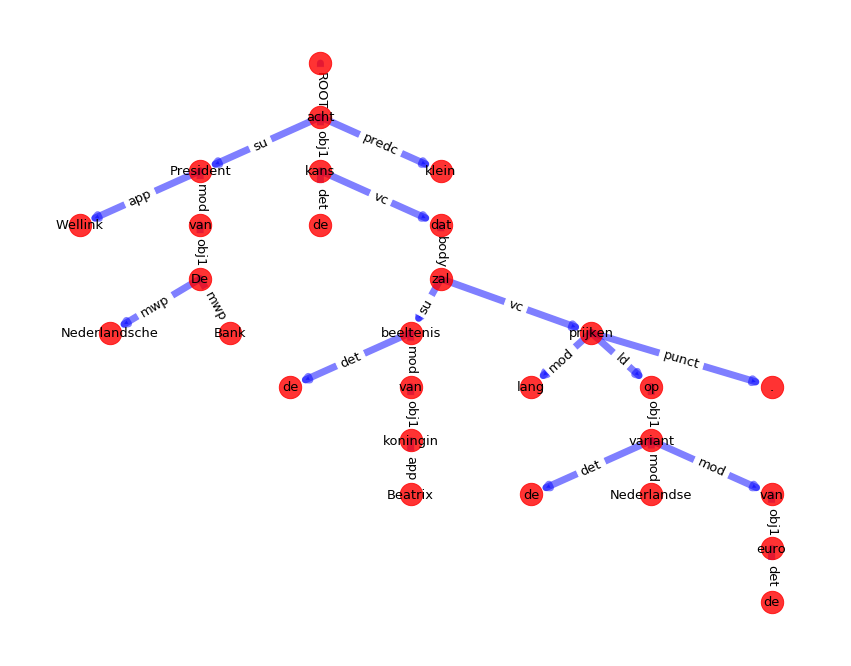

In [6]:
sentence = """1	President	president	noun	7	su	_	_
2	Wellink	Wellink	name	1	app	_	_
3	van	van	prep	1	mod	_	_
4	De	De	name	3	obj1	_	_
5	Nederlandsche	Nederlandsche	name	4	mwp	_	_
6	Bank	Bank	name	4	mwp	_	_
7	acht	acht	verb	0	ROOT	_	_
8	de	de	det	9	det	_	_
9	kans	kans	noun	7	obj1	_	_
10	klein	klein	adj	7	predc	_	_
11	dat	dat	comp	9	vc	_	_
12	de	de	det	13	det	_	_
13	beeltenis	beeltenis	noun	25	su	_	_
14	van	van	prep	13	mod	_	_
15	koningin	koningin	noun	14	obj1	_	_
16	Beatrix	Beatrix	name	15	app	_	_
17	lang	lang	adj	26	mod	_	_
18	op	op	prep	26	ld	_	_
19	de	de	det	21	det	_	_
20	Nederlandse	Nederlands	adj	21	mod	_	_
21	variant	variant	noun	18	obj1	_	_
22	van	van	prep	21	mod	_	_
23	de	de	det	24	det	_	_
24	euro	euro	noun	22	obj1	_	_
25	zal	zal	verb	11	body	_	_
26	prijken	prijk	verb	25	vc	_	_
27	.	.	punct	26	punct	_	_"""
ss = [(lid+111, line) for lid, line in enumerate(sentence.split('\n'))]
sent = SentenceGraph(sentence=ss, formatter=formatter, fname="example_file")
sent.show(figsize=(15.0, 12.0), v_label='FORM', e_label='DEPREL')

### Read sub-graph patterns and target-feature macros

Read patterns from file of GraphML notation

GraphML notation:
```xml
<graphml xmlns="http://graphml.graphdrawing.org/xmlns"
      xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
      xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns
        http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">
    <key id="n1" for="node" attr.name="LEMMA" attr.type="string">
        <default>(\w+)</default>
    </key>
    <key id="n2" for="node" attr.name="POS" attr.type="string">
        <default>\w+</default>
    </key>
    <key id="e1" for="edge" attr.name="DEPREL" attr.type="string"/>
    <graph id="1" edgedefault="directed">
        <node id="1">
            <data key="n2">(V)\w*</data>
        </node>
        <node id="2">
            <data key="n2">(N)\w*</data>
        </node>
        <edge source="1" target="2">
            <data key="e1">(nsubj)$</data>
        </edge>
    </graph>
</graphml>
```

First, set node attributes by `<key></key>` tag. Set different `id`s for different node and edge attributes. Set the `attr.name` with the corresponding column name of `global-columns`.  
Then set every sub-graph pattern in a `<graph></graph>` tag. The content in the `data` tag of each node or edge should be the corresponding regular expression.

Generate target-feature macro

Specify the target format and feature format: string representation of node format and edge format.
```xml
<?xml version="1.0" encoding="UTF-8"?>
<target-feature-list>
    <target-fmt>
        <node-fmt>
            <LEMMA group="1"/>
            <POS group="1"/>
            <string connector="/">LEMMA/POS</string>
        </node-fmt>
    </target-fmt>
    <feature-fmt>
        <node-fmt>
            <LEMMA group="1"/>
            <POS group="1"/>
            <string connector="/">LEMMA/POS</string>
        </node-fmt>
        <edge-fmt>DEPREL</edge-fmt>
    </feature-fmt>
    ...
</target-feature-list>
```

`target-fmt` tag sets the node format of the target with the corresponding one in settings. `feature-fmt` tag sets the node and edge format of the feature with the same one in settings.

Specify the `sub-graph-pattern id`, the target `node id`, and the target description and feature description.
```xml
<?xml version="1.0" encoding="UTF-8"?>
<target-feature-list>
    ...
    <target-feature-macro id="1">
        <sub-graph-pattern id="1"/>
        <target nodeID="2">
            <description>noun</description>
        </target>
        <feature>
            <description>subject of verb</description>
        </feature>
    </target-feature-macro>
    ...
</target-feature-list>
```
In each `target-feature-macro` tag, set the `sub-graph-pattern` with the id of the pattern used for this macro. Set the node id of target and the description for target and feature (but they are not important).

### Templates interested

I'm interested in 5 templates, covering all combinations of one-  and two-step distances.

1. Words that depend directly on the target.  
E.g. _**een** heel **mooie** stof_: stof -> de; stof -> mooi (one-step, target is head)
2. Words the target depends directly on.  
E.g. _ik hou **van** die stof_: van -> stof (one-step, target is dependent)
3. Words that depend on something that depends on the target.  
E.g. _een **heel** mooie stof_: stof -> mooi -> heel (two-step, straight, target is head). The intermediate item would be covered by template 1.
4. Words that are the head of the head that the target depends on.  
E.g. _ik **hou** van die stof_: houden -> van -> stof (two-step, straight, target is dependent). The intermediate item would be covered by template 2.
5. Words that depend on the head that the target also depends on.  
E.g. _**ik** vind die stof leuk_: vinden -> ik; vinden -> stof (two-step, not straight).

The GraphML patterns that correspond to your __templates__ should be:
```xml
<graphml xmlns="http://graphml.graphdrawing.org/xmlns"
      xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
      xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns
        http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">
    <key id="n1" for="node" attr.name="LEMMA" attr.type="string">
        <default>(\w+)</default>
    </key>
    <key id="n2" for="node" attr.name="POS" attr.type="string">
        <default>(\w+)</default>
    </key>
    <key id="e1" for="edge" attr.name="DEPREL" attr.type="string"/>
    <graph id="1" edgedefault="directed">
        <node id="1">
            <data key="n2">(\w+)</data>
        </node>
        <node id="2">
            <data key="n2">(\w+)</data>
        </node>
        <edge source="1" target="2">
            <data key="e1">\w+</data>
        </edge>
    </graph>
    <graph id="2" edgedefault="directed">
        <node id="1">
            <data key="n2">(\w+)</data>
        </node>
        <node id="2">
            <data key="n2">(\w+)</data>
        </node>
        <node id="3">
            <data key="n2">(\w+)</data>
        </node>
        <edge source="1" target="2">
            <data key="e1">\w+</data>
        </edge>
        <edge source="2" target="3">
            <data key="e1">\w+</data>
        </edge>
    </graph>
    <graph id="3" edgedefault="directed">
        <node id="1">
            <data key="n2">(\w+)</data>
        </node>
        <node id="2">
            <data key="n2">(\w+)</data>
        </node>
        <node id="3">
            <data key="n2">(\w+)</data>
        </node>
        <edge source="1" target="2">
            <data key="e1">\w+</data>
        </edge>
        <edge source="1" target="3">
            <data key="e1">\w+</data>
        </edge>
    </graph>
</graphml>
```

The XML target-feature macros should be
```xml
<?xml version="1.0" encoding="UTF-8"?>
<target-feature-list>
    <target-fmt>
        <node-fmt>
            <LEMMA group="1"/>
            <POS group="1"/>
            <string connector="/">LEMMA/POS</string>
        </node-fmt>
    </target-fmt>
    <feature-fmt>
        <node-fmt>
            <LEMMA group="1"/>
            <POS group="1"/>
            <string connector="/">LEMMA/POS</string>
        </node-fmt>
        <edge-fmt>DEPREL</edge-fmt>
    </feature-fmt>
    <target-feature-macro id="1">
        <sub-graph-pattern id="1"/>
        <target nodeID="2">
        </target>
        <feature>
            <description>Words that depend directly on the target.</description>
        </feature>
    </target-feature-macro>
    <target-feature-macro id="2">
        <sub-graph-pattern id="1"/>
        <target nodeID="1">
        </target>
        <feature>
            <description>Words the target depends directly on.</description>
        </feature>
    </target-feature-macro>
    <target-feature-macro id="3">
        <sub-graph-pattern id="2"/>
        <target nodeID="3">
        </target>
        <feature>
            <description>Words that depend on something that depends on the target.</description>
        </feature>
    </target-feature-macro>
    <target-feature-macro id="4">
        <sub-graph-pattern id="2"/>
        <target nodeID="1">
        </target>
        <feature>
            <description>Words that are the head of the head that the target depends on.</description>
        </feature>
    </target-feature-macro>
    <target-feature-macro id="5">
        <sub-graph-pattern id="3"/>
        <target nodeID="1">
        </target>
        <feature>
            <description>Words that depend on the head that the target also depends on.</description>
        </feature>
    </target-feature-macro>
</target-feature-list>
```

In [7]:
graphml_fname = "/home/tao/Projects/mariana/QLVLNews.template.graphml"
patterns = PatternGraph.read_graphml(graphml_fname)

macro_fname = "/home/tao/Projects/mariana/QLVLNews.target-feature-macro.xml"
macros = MacroGraph.read_xml(macro_fname, patterns)

Before you use sub-graph patterns and target-feature macros in building dependency, you should use the following function to check the patterns or macros.

In [8]:
def plot_patterns():
    plt.rcParams['figure.figsize'] = (20.0, 32.0)
    for i in range(len(macros)):
        plt.subplot(5, 2, i+1)
        draw_labels(macros[i].graph, v_labels='POS', e_labels='DEPREL')
    plt.show()

# plot_patterns()

### Match multiple files

In [9]:
ifhan = ItemFreqHandler(settings)
total_vocab = ifhan.build_item_freq()

Building item frequency list...


In [10]:
vocab = total_vocab[total_vocab.freq >= 10]
vocab = vocab[:-100]
print(vocab.describe())

Total items: 1782
Total freqs: 145979
count   1782.000000
mean      81.918631
std      468.373350
min       10.000000
25%       13.000000
50%       19.000000
75%       37.000000
max    10686.000000


In [11]:
# vocab.dataframe.head(30)
# select two types: "heb/verb", "word/verb"
test_vocab = vocab.subvocab(["heb/verb", "word/verb"])
test_vocab

[('heb/verb', 1545),('word/verb', 1241)]

In [12]:
dephan = DepRelHandler(settings, workers=4, targets=test_vocab, mode='token')
dephan.read_templates(macros=macros)
freqMTX = dephan.build_dependency(fnames=qlvl_files)
freqMTX

Building dependency features...



Building matrix...


[2753, 4029]                               0/num  1/noun  1/num  10/num  100/num  103/num  119/num  ...
heb/verb/nrc_handelsblad_19990104_101/675  NaN    NaN     NaN    NaN     NaN      NaN      NaN      ...
heb/verb/nrc_handelsblad_19990104_101/806  NaN    NaN     NaN    NaN     NaN      NaN      NaN      ...
heb/verb/nrc_handelsblad_19990104_102/24   NaN    NaN     NaN    NaN     NaN      NaN      NaN      ...
heb/verb/nrc_handelsblad_19990104_105/105  NaN    NaN     NaN    NaN     NaN      NaN      NaN      ...
heb/verb/nrc_handelsblad_19990104_105/123  NaN    NaN     NaN    NaN     NaN      NaN      NaN      ...
heb/verb/nrc_handelsblad_19990104_105/37   NaN    NaN     NaN    NaN     NaN      NaN      NaN      ...
heb/verb/nrc_handelsblad_19990104_105/64   NaN    NaN     NaN    NaN     NaN      NaN      NaN      ...
...                                        ...    ...     ...    ...     ...      ...      ...      ...

In [13]:
print(freqMTX.describe())
freqMTX.count_nonzero()

*******Matrix Description*******
  matrix shape:	2753 X 4029
  is sparse:	True
  num of eles:	14673
  density:	0.13%
********************************


array([ 7,  6,  6, ...,  6,  6, 12])

In [14]:
dephan = DepRelHandler(settings, workers=4, targets=test_vocab, mode='type')
dephan.read_templates(macros=macros)
freqMTX = dephan.build_dependency(fnames=qlvl_files)
freqMTX

Building dependency features...



Building matrix...


[2, 4029]  0/num  1/noun  1/num  10/num  100/num  103/num  119/num  ...
heb/verb   1      NaN     2      1       1        NaN      NaN      ...
word/verb  NaN    1       1      NaN     NaN      5        2        ...

## Format of results (tokens)

\[From Mariana\] 
* First, I obtained the list of files that I used for my cloud AND are among the files I sent you (19 cases). 
* Then, I retrieved the context of the tokens and listed the types that correspond to my templates. 
* By running those functions, you should see the types returned by each template in the templates dictionary  
  (called temp1, temp2… temp5 to match the ones your model should return)  
  and all the types returned for each token in the results dictionary. 
* After running the dependency, I displayed the original token-position matrix and then showed what information I'm expecting from the dependency data to adapt the token-position matrix (using the data from the results dictionary).

In [1]:
from pathlib import Path
qlvl_files = list(Path('/home/tao/Projects/mariana/QLVLNews/').iterdir())
print(len(qlvl_files))

428


In [19]:
total_vocab['zwart/adj']

19

In [16]:
extokfname = "/home/tao/Projects/mariana/zwart.tcmx.pos.pac"
tokmx = TypeTokenMatrix.load(extokfname)
print(tokmx.shape)
# file names in targets
tokfiles = [tok.split('/')[2] for tok in tokmx.row_items]
tokfiles[:3]

(300, 1306)


['nrc_handelsblad_20030930_96',
 'nrc_handelsblad_20000207_58',
 'nrc_handelsblad_20000824_137']

In [21]:
allfnames = [os.path.basename(fname).rsplit('.', 1)[0] 
             for fname in qlvl_files]
print(allfnames[:3])
set(tokfiles).intersection(set(allfnames))

['nrc_handelsblad_19990112_135', 'nrc_handelsblad_19990108_117', 'nrc_handelsblad_19990108_138']


set()

In [23]:
# ids = [x for x in tokenMatrix.row_items if x.split('/')[2] in zfiles]
# tokens = dict([(x.split('/')[2], x.split('/')[3]) for x in ids])
ids = tokmx.row_items
tokens = dict(map(lambda x: x.split('/')[2:], ids))
print(ids[:3])
print(list(tokens.items())[:3])

['zwart/adj/nrc_handelsblad_20030930_96/232', 'zwart/adj/nrc_handelsblad_20000207_58/1074', 'zwart/adj/nrc_handelsblad_20000824_137/88']
[('nrc_handelsblad_20030930_96', '232'), ('nrc_handelsblad_20000207_58', '1074'), ('nrc_handelsblad_20000824_137', '88')]


I'm interested in 5 templates, covering all combinations of one-  and two-step distances.

1. Words that depend directly on the target.  
E.g. _**een** heel **mooie** stof_: stof -> de; stof -> mooi (one-step, target is head)
2. Words the target depends directly on.  
E.g. _ik hou **van** die stof_: van -> stof (one-step, target is dependent)
3. Words that depend on something that depends on the target.  
E.g. _een **heel** mooie stof_: stof -> mooi -> heel (two-step, straight, target is head). The intermediate item would be covered by template 1.
4. Words that are the head of the head that the target depends on.  
E.g. _ik **hou** van die stof_: houden -> van -> stof (two-step, straight, target is dependent). The intermediate item would be covered by template 2.
5. Words that depend on the head that the target also depends on.  
E.g. _**ik** vind die stof leuk_: vinden -> ik; vinden -> stof (two-step, not straight).

In [ ]:
# columns:
# 
for file in files:
    with open(file, encoding = 'latin1') as f:
        text = f.readlines()
        fname = file.rsplit('/', 1)[1].split('.')[0]
        t = int(tokens[fname])  # line number
        token_id = 'zwart/adj/' + fname + '/' + str(t)
        this_idx = int(text[t-1].split('\t')[0])  # current word id of this line
        start = t-this_idx
        end = t+text[t:].index('</sentence>\n')
        minitext = [x.split('\t') for x in text[start:end]]  # sentence?
        
        this_head = text[t-1].split('\t')[4]  # headID
        temp1 = [x[2]+'/'+x[3] for x in minitext if x[4] == str(this_idx)]
        temp2 = [x[2]+'/'+x[3] for x in minitext if x[0] == this_head]
        dep_idx = [x[0] for x in minitext if x[4] == str(this_idx)]
        head_head = [x[4] for x in minitext if x[0] == this_head][0]
        temp3 = [x[2]+'/'+x[3] for x in minitext if x[4] in dep_idx]
        temp4 = [x[2]+'/'+x[3] for x in minitext if x[0] == head_head]
        temp5 = [x[2]+'/'+x[3] for x in minitext if (x[4] == this_head and not x[0] == str(this_idx))]

        # results for the 5 templates
        template_results = {'temp1':temp1, 'temp2':temp2, 'temp3':temp3, 'temp4':temp4, 'temp5':temp5}
        cws = temp1 + temp2 + temp3 + temp4 + temp5
        templates[token_id] = template_results
        results[token_id] = cws